In [448]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
plt.style.use('ggplot')


In [2]:
### Creates initial dataframe from .txt files
parties = ['republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'democrat']
pres = ['bush', 'carter', 'clinton', 'eisenhower', 'fdroosevelt', 'ford', 'gwbush', 'hoover', 'kennedy', 'lbjohnson', 'nixon', 'obama', 'reagan', 'truman']
war = ['war', 'nw', 'nw', 'nw', 'war', 'nw', 'war', 'nw', 'war', 'war', 'war', 'war', 'nw', 'war']
pres_dict = {}
for i, v in enumerate(pres):
    pres_dict[v]= {}
    pres_dict[v]['party'] = parties[i]

## imports .txt files and puts them into a dictionary
import os
data = []
for i, p in enumerate(pres):
    folder = 'corpus/' + p + '/'
    for filename in os.listdir(folder): 
        indiv = []
        indiv.append(p)
        indiv.append(parties[i])
        indiv.append(war[i])
        path = folder + filename
        if os.path.isfile(path) and filename.endswith(".txt"): 
            with open(path, "r") as file: 
                indiv.append(file.read())
            data.append(indiv)

# for filename in os.listdir('corpus_addendum/'): 
#     indiv = []
#     path = folder + filename
#     print(path)
#     if os.path.isfile(path) and filename.endswith(".txt"): 
#         with open(path, "r") as file:
#             p = filename.split('-')[1][:-4]
#             indiv.append(p)
#             indiv.append(pres_dict[p]['party'])
#             indiv.append(file.read())
#     data.append(indiv)

#converts the dictionary to a dataframe
df = pd.DataFrame (data, columns = ['name', 'party', 'war','speech'])

### splits the speech into title, date, text
def get_text(x):
    idx = x.find('>', x.find('>')+1, 100)
    return x[idx+1:]

df['title'] = df['speech'].apply(lambda x: x.split('"')[1])
df['date'] = df['speech'].apply(lambda x: x.split('"')[3])
df['text'] = df['speech'].apply(get_text)

def is_speech_type(string, speech_type):
    if string.lower().find(speech_type)>=0:
        return True
    else:
        return False

speech_type = ['interview', 'debate', 'inaugural address', 'state of the union', 'press conference']
for i in speech_type:
    df[i] = df.title.apply(lambda x: is_speech_type(x, i))

## Use this function to find parts of the debates that belong to each speaker
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            result += s[start:end] + ' '
            s = s[end:]
        except ValueError:
            return result

In [3]:
df.head()

name       party  war                                             speech  \
0  bush  republican  war  <title="Address at West Point">\n<date="Januar...   
1  bush  republican  war  <title="Address on Somalia">\n<date="December ...   
2  bush  republican  war  <title="Address on Iraq's Invasion of Kuwait">...   
3  bush  republican  war  <title="Address Before a Joint Session of Cong...   
4  bush  republican  war  <title="Remarks at Texas A and M University">\...   

                                        title                date  \
0                       Address at West Point     January 5, 1993   
1                          Address on Somalia    December 4, 1992   
2        Address on Iraq's Invasion of Kuwait      August 8, 1990   
3  Address Before a Joint Session of Congress  September 11, 1990   
4         Remarks at Texas A and M University   December 15, 1992   

                                                text  interview  debate  \
0  \nThank you all very much. Good luck. Please b...      False   False   
1  \nI want to talk to you today about the traged...      False   False   
2  \nIn the life of a nation, we're called upon t...      False   False   
3  \nMr. President and Mr. Speaker and Members of...      False   False   
4  \nThank you all for that welcome back. Thank y...      False   False   

   inaugural address  state of the union  press conference  
0              False               False             False  
1              False               False             False  
2              False               False             False  
3              False               False             False  
4              False               False             False

In [4]:
df.head()

name       party  war                                             speech  \
0  bush  republican  war  <title="Address at West Point">\n<date="Januar...   
1  bush  republican  war  <title="Address on Somalia">\n<date="December ...   
2  bush  republican  war  <title="Address on Iraq's Invasion of Kuwait">...   
3  bush  republican  war  <title="Address Before a Joint Session of Cong...   
4  bush  republican  war  <title="Remarks at Texas A and M University">\...   

                                        title                date  \
0                       Address at West Point     January 5, 1993   
1                          Address on Somalia    December 4, 1992   
2        Address on Iraq's Invasion of Kuwait      August 8, 1990   
3  Address Before a Joint Session of Congress  September 11, 1990   
4         Remarks at Texas A and M University   December 15, 1992   

                                                text  interview  debate  \
0  \nThank you all very much. Good luck. Please b...      False   False   
1  \nI want to talk to you today about the traged...      False   False   
2  \nIn the life of a nation, we're called upon t...      False   False   
3  \nMr. President and Mr. Speaker and Members of...      False   False   
4  \nThank you all for that welcome back. Thank y...      False   False   

   inaugural address  state of the union  press conference  
0              False               False             False  
1              False               False             False  
2              False               False             False  
3              False               False             False  
4              False               False             False

In [5]:
idx = [5 ,13, 23, 26, 28, 41,60, 252, 253, 260, 265, 449, 453]
opponent = [['clinton', 'democrat'], ['dukakis', 'democrat'], ['ford', 'republican'], ['ford', 'republican'],
            ['ford', 'republican'], ['reagan', 'republican'], ['dole', 'republican'], ['nixon', 'republican'], ['nixon', 'republican'],
            ['nixon', 'republican'], ['nixon', 'republican'], ['mondale','democrat'], ['mondale','democrat']]
        
delimiters = [['Bush.>', '>', '<Governor Clinton.', '>'], ['BUSH:>', '<', '<DUKAKIS:','>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'],['THE PRESIDENT.>', '<', '<GOVERNOR REAGAN.', '>'],
             ['<PRESIDENT CLINTON:>', '<', '<SENATOR DOLE:', '<'],['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'],
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], 
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<The President.>', '<', '<Mr. Mondale.', '>'],
              ['<PRESIDENT REAGAN:>', '<', '<MR. MONDALE:', '>']]
opponents = []
for i in range(len(idx)):
    text = df.loc[idx[i], 'text']
    df.loc[idx[i],'text'] = find_between(df.loc[idx[i],'text'], delimiters[i][0], delimiters[i][1])
    opponent_text = find_between(text, delimiters[i][2], delimiters[i][3])
    opponents.append(opponent[i] + [0, 0, 0, 0] + [opponent_text] + [False, True, False, False, False])
opponents = pd.DataFrame(data = opponents, columns = df.columns)
df = pd.concat([df, opponents])

In [6]:
import pprint
# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

url = 'https://www.debates.org/voter-education/debate-transcripts/'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

classes = []
class_num = [i for i in range(100, 141)]
for v in [138, 139, 133, 140, 135, 136, 137, 134, 130, 132, 129, 127, 121, 122, 118, 101]:
    class_num.remove(v)

for i in class_num:
    classes.append("page_item page-item-"+str(i))

debate_names = [['kaine', 'democrat', 'pence', 'republican'], ['obama', 'democrat', 'romney', 'republican'],
                ['obama', 'democrat', 'romney', 'republican'], ['biden', 'democrat', 'ryan', 'republican'],
               ['obama', 'democrat', 'romney', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['biden', 'democrat', 'palin', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['mccain', 'republican', 'obama', 'democrat'], ['bush', 'republican', 'kerry', 'democrat'],
               ['bush','republican','kerry','democrat'], ['cheney', 'republican', 'edwards', 'democrat'],
               ['bush', 'republican', 'kerry', 'democrat'], ['gore', 'democrat', 'bush', 'republican'],
                ['lieberman', 'democrat', 'cheney', 'republican'], ['gore', 'democrat', 'bush', 'republican'],
                ['gore', 'democrat', 'bush', 'republican'], ['gore', 'democrat', 'kemp', 'republican'],
                ['clinton', 'democrat', 'dole', 'republican'], ['gore', 'democrat', 'quayle', 'republican'],
                ['clinton', 'democrat', 'bush', 'republican'], ['clinton', 'democrat', 'bush', 'republican'],
                ['bush', 'republican', 'dukakis', 'democrat'], ['bentsen', 'democrat', 'quayle', 'republican'],
                ['bush', 'republican','ferraro', 'democrat']]

### Gets text from each speech
links = []
for i in classes:
    x = soup.find_all(class_= i)
    links.append('http://debates.org/'+ str(x).split('"')[3])


results = []
for i, link in enumerate(links):
    req = requests.get(link)
    soup_link = BeautifulSoup(req.content, 'html.parser')
    text = soup_link.get_text()
    text = text.lower()
    for v in [0, 2]:
        text_1 = find_between(text, '\n'+debate_names[i][v]+":", ':')
        results.append([debate_names[i][v], debate_names[i][v+1]] + [0, 0, 0, 0] + [text_1] + [False, True, False, False, False])
for i in [18, 20, 24, 27, 31, 33]:
     results[i][0]=results[i][0].replace("bush", "gwbush")
more_debates = pd.DataFrame(data = results, columns = df.columns)
df = pd.concat([df, more_debates])


In [260]:
df = df.reset_index()

In [267]:
df.index

RangeIndex(start=0, stop=549, step=1)

## EDA!

Counts of types and presidents

In [233]:
df.count()

name                  549
party                 549
war                   549
speech                549
title                 549
date                  549
text                  549
interview             549
debate                549
inaugural address     549
state of the union    549
press conference      549
text length           549
accurate              549
dtype: int64

In [234]:
print('Speeches by president')
print(df.name.value_counts())
print('')
print('speeches by party')
print(df.party.value_counts())

Speeches by president
lbjohnson      71
reagan         60
obama          54
fdroosevelt    49
kennedy        45
gwbush         45
clinton        43
hoover         29
bush           27
nixon          27
carter         22
truman         19
ford           17
eisenhower      6
gore            5
kerry           3
romney          3
mccain          3
biden           2
quayle          2
cheney          2
dole            2
dukakis         2
mondale         2
ryan            1
kemp            1
bentsen         1
palin           1
pence           1
kaine           1
ferraro         1
lieberman       1
edwards         1
Name: name, dtype: int64

speeches by party
democrat      322
republican    227
Name: party, dtype: int64


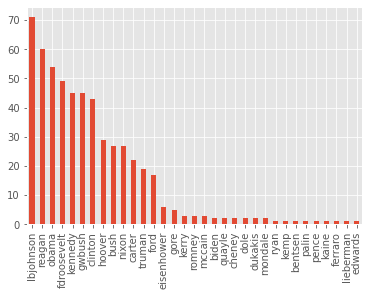

In [235]:
df['name'].value_counts().plot(kind='bar')

LBJ had the most speeches, which lead me to wonder if these were disproportionately press conferences due to the Vietnam War.  It turns out that yes, he had the most press conferences in the corpus, 23 in total.

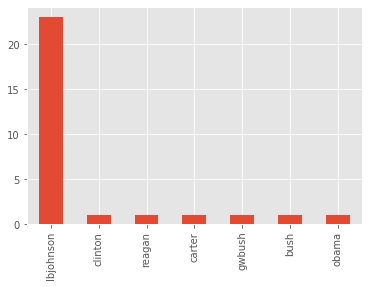

In [236]:
df[df['press conference']== True]['name'].value_counts().plot(kind='bar')

In [237]:
df.groupby('name').sum()

interview  debate  inaugural address  state of the union  \
name                                                                    
bentsen            0.0     1.0                0.0                 0.0   
biden              0.0     2.0                0.0                 0.0   
bush               0.0     6.0                1.0                 3.0   
carter             0.0     4.0                1.0                 3.0   
cheney             0.0     2.0                0.0                 0.0   
clinton            0.0     5.0                0.0                 7.0   
dole               0.0     2.0                0.0                 0.0   
dukakis            0.0     2.0                0.0                 0.0   
edwards            0.0     1.0                0.0                 0.0   
eisenhower         0.0     0.0                1.0                 0.0   
fdroosevelt        0.0     0.0                4.0                 3.0   
ferraro            0.0     1.0                0.0                 0.0   
ford               0.0     3.0                0.0                 3.0   
gore               0.0     5.0                0.0                 0.0   
gwbush             0.0     6.0                2.0                 7.0   
hoover             0.0     0.0                1.0                 4.0   
kaine              0.0     1.0                0.0                 0.0   
kemp               0.0     1.0                0.0                 0.0   
kennedy            0.0     4.0                1.0                 3.0   
kerry              0.0     3.0                0.0                 0.0   
lbjohnson          0.0     0.0                1.0                 6.0   
lieberman          0.0     1.0                0.0                 0.0   
mccain             0.0     3.0                0.0                 0.0   
mondale            0.0     2.0                0.0                 0.0   
nixon              0.0     4.0                2.0                 4.0   
obama              0.0     6.0                2.0                 7.0   
palin              0.0     1.0                0.0                 0.0   
pence              0.0     1.0                0.0                 0.0   
quayle             0.0     2.0                0.0                 0.0   
reagan             0.0     3.0                2.0                 7.0   
romney             0.0     3.0                0.0                 0.0   
ryan               0.0     1.0                0.0                 0.0   
truman             0.0     0.0                1.0                 0.0   

             press conference  text length  
name                                        
bentsen                   0.0         5683  
biden                     0.0        12187  
bush                      1.0        93880  
carter                    1.0        68413  
cheney                    0.0        12733  
clinton                   1.0       157844  
dole                      0.0        14511  
dukakis                   0.0         5361  
edwards                   0.0         5768  
eisenhower                0.0        17689  
fdroosevelt               0.0       130437  
ferraro                   0.0         5579  
ford                      0.0        54181  
gore                      0.0        30973  
gwbush                    1.0       145039  
hoover                    0.0        87677  
kaine                     0.0         7559  
kemp                      0.0         6955  
kennedy                   0.0       133613  
kerry                     0.0        16341  
lbjohnson                23.0       249063  
lieberman                 0.0         6733  
mccain                    0.0        24024  
mondale                   0.0         9465  
nixon                     0.0        85573  
obama                     1.0       237484  
palin                     0.0         7062  
pence                     0.0         8058  
quayle                    0.0         9232  
reagan                    1.0       200803  
romney           

In [238]:
df['text length'] = df.text.apply(lambda x: len(x.split(' ')))

Assuming 150 words spoken per minute, speeches were on average 23 minutes long

In [546]:
df['text length'].median()/150

21.173333333333332

In [547]:
df.sort_values(by='text length', ascending=True)

index         name       party  war  \
544     45      dukakis    democrat    0   
120    120  fdroosevelt    democrat  war   
202    202       hoover  republican   nw   
307    307    lbjohnson    democrat  war   
355    355        nixon  republican  war   
480    480       truman    democrat  war   
432    432       reagan  republican   nw   
200    200       hoover  republican   nw   
319    319    lbjohnson    democrat  war   
118    118  fdroosevelt    democrat  war   
195    195       hoover  republican   nw   
211    211       hoover  republican   nw   
251    251      kennedy    democrat  war   
272    272    lbjohnson    democrat  war   
229    229      kennedy    democrat  war   
128    128  fdroosevelt    democrat  war   
61      61      clinton    democrat   nw   
292    292    lbjohnson    democrat  war   
114    114  fdroosevelt    democrat  war   
178    178       gwbush  republican  war   
350    350        nixon  republican  war   
208    208       hoover  republican   nw   
187    187       gwbush  republican  war   
149    149         ford  republican   nw   
204    204       hoover  republican   nw   
256    256      kennedy    democrat  war   
192    192       hoover  republican   nw   
436    436       reagan  republican   nw   
224    224      kennedy    democrat  war   
31      31       carter    democrat   nw   
172    172       gwbush  republican  war   
271    271    lbjohnson    democrat  war   
290    290    lbjohnson    democrat  war   
351    351        nixon  republican  war   
467    467       truman    democrat  war   
413    413       reagan  republican   nw   
34      34       carter    democrat   nw   
71      71      clinton    democrat   nw   
416    416       reagan  republican   nw   
10      10         bush  republican  war   
301    301    lbjohnson    democrat  war   
481    481       truman    democrat  war   
14      14         bush  republican  war   
478    478       truman    democrat  war   
209    209       hoover  republican   nw   
43      43       carter    democrat   nw   
330    330    lbjohnson    democrat  war   
147    147         ford  republican   nw   
322    322    lbjohnson    democrat  war   
217    217       hoover  republican   nw   
458    458       reagan  republican   nw   
328    328    lbjohnson    democrat  war   
30      30       carter    democrat   nw   
184    184       gwbush  republican  war   
365    365        obama    democrat  war   
175    175       gwbush  republican  war   
300    300    lbjohnson    democrat  war   
249    249      kennedy    democrat  war   
68      68      clinton    democrat   nw   
191    191       gwbush  republican  war   
74      74      clinton    democrat   nw   
439    439       reagan  republican   nw   
396    396        obama    democrat  war   
213    213       hoover  republican   nw   
239    239      kennedy    democrat  war   
434    434       reagan  republican   nw   
408    408       reagan  republican   nw   
205    205       hoover  republican   nw   
66      66      clinton    democrat   nw   
291    291    lbjohnson    democrat  war   
242    242      kennedy    democrat  war   
156    156       gwbush  republican  war   
67      67      clinton    democrat   nw   
174    174       gwbush  republican  war   
295    295    lbjohnson    democrat  war   
81      81      clinton    democrat   nw   
203    203       hoover  republican   nw   
148    148         ford  republican   nw   
77      77      clinton    democrat   nw   
18      18         bush  republican  war   
312    312    lbjohnson    democrat  war   
1        1         bush  republican  war   
82      82      clinton    democrat   nw   
167    167       gwbush  republican  war   
228    228      kennedy    democrat  war   
331    331    lbjohnson    democrat  war   
424    424       reagan  republican   nw   
470    470       truman    democrat  war   
293    293    lbjohnson    democrat  war   
484    484       truman    democrat  war   
3

In [548]:
df.iloc[120].text

'<title="Message to Congress Requesting War Declarations with Germany and Italy">\n<date="December 11, 1941">\nTo the Congress:\nOn the morning of December eleventh, the Government of Germany, pursuing its course of world conquest, declared war against the United States.\nThe long known and the long expected has thus taken place. The forces endeavoring to enslave the entire world now are moving toward this hemisphere.\nNever before has there been a greater challenge to life, liberty, and civilization.\nDelay invites greater danger. Rapid and united effort by all of the peoples of the world who are determined to remain free will insure a world victory of the forces of justice and of righteousness over the forces of savagery and of barbarism.\nItaly also has declared war against the United States.\nI therefore request the Congress to recognize a state of war between the United States and Germany, and between the United States and Italy.\n'

In [241]:
vocab = set()
total = []
df['text'].str.lower().str.split().apply(vocab.update)
df['text'].str.lower().str.split().apply(total.append)
total = [item for sublist in total for item in sublist]
print(f'The vocabulary of the corpus is {len(vocab)} unique words & {len(total)} total words.')

The vocabulary of the corpus is 57629 unique words & 1928737 total words.


In [242]:
new = df.copy()

In [268]:
for i in vocab:
    instance = 0
    for j in range(549):
        if ' '+i+' ' in new.loc[j, 'text']:
            instance += 1

KeyError: 486

In [94]:
print('According to the count vectorizer the number of words is 25518')

According to the count vectorizer the number of words is 25518


In [244]:
count_vector = CountVectorizer(stop_words='english', max_features=None)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
BoW = pd.DataFrame(X.toarray(), columns=labels)


Text(0.5, 1.0, 'Word Count by Party')

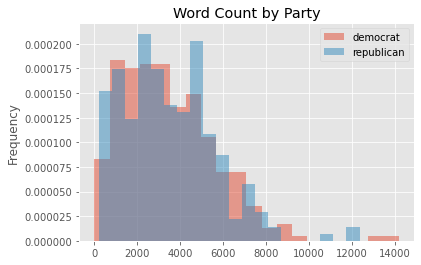

In [544]:
fig, ax = plt.subplots()
df[df['party'] == 'democrat']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'democrat')
df[df['party'] == 'republican']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'republican')
ax.legend()
ax.set_title('Word Count by Party')

In [247]:
df[df['name'] == 'obama']

name     party  war                                             speech  \
360  obama  democrat  war  <title="Commencement Address at Rutgers Univer...   
361  obama  democrat  war  <title="2016 State of the Union Address">\n<da...   
362  obama  democrat  war  <title="Acceptance Speech at the Democratic Na...   
363  obama  democrat  war  <title="Address on the End of the Combat Missi...   
364  obama  democrat  war  <title="Speech on the BP Oil Spill">\n<date="J...   
365  obama  democrat  war  <title="Remarks on the Lilly Ledbetter Fair Pa...   
366  obama  democrat  war  <title="Speech on Health Care Reform">\n<date=...   
367  obama  democrat  war  <title="Inaugural Address">\n<date="January 20...   
368  obama  democrat  war  <title="2012 State of the Union Address">\n<da...   
369  obama  democrat  war  <title="Nominee Acceptance Speech at 2012 Demo...   
370  obama  democrat  war  <title="Remarks on Election Night">\n<date="No...   
371  obama  democrat  war  <title="Remarks on Space Exploration in the 21...   
372  obama  democrat  war  <title="Remarks on Trayvon Martin">\n<date="Ju...   
373  obama  democrat  war  <title="Acceptance of Nobel Peace Prize">\n<da...   
374  obama  democrat  war  <title="Remarks on Nominating Judge Sonia Soto...   
375  obama  democrat  war  <title="Remarks on the American Recovery and R...   
376  obama  democrat  war  <title="Address to Congress on Health Care">\n...   
377  obama  democrat  war  <title="Remarks on Education and the Economy">...   
378  obama  democrat  war  <title="Address at Cairo University">\n<date="...   
379  obama  democrat  war  <title="News Conference on Congressional Gridl...   
380  obama  democrat  war  <title="Remarks on Wall Street Reform">\n<date...   
381  obama  democrat  war  <title="Address Before a Joint Session of Cong...   
382  obama  democrat  war  <title="2011 State of the Union Address">\n<da...   
383  obama  democrat  war  <title="Speech on Gun Violence">\n<date="April...   
384  obama  democrat  war  <title="Address to the People of Israel">\n<da...   
385  obama  democrat  war  <title="Speech on American Diplomacy in the Mi...   
386  obama  democrat  war  <title="2013 State of the Union Address">\n<da...   
387  obama  democrat  war  <title="Remarks at Memorial for Victims of the...   
388  obama  democrat  war  <title="Speech on Strategy in Afghanistan and ...   
389  obama  democrat  war  <title="2010 State of the Union Address">\n<da...   
390  obama  democrat  war  <title="Remarks on the Death of Osama Bin Lade...   
391  obama  democrat  war  <title="Statement on the Government Sequester"...   
392  obama  democrat  war  <title="Press Conference After 2010 Midterm El...   
393  obama  democrat  war  <title="2012 Election Night Victory Speech">\n...   
394  obama  democrat  war  <title="Remarks on Sandy Hook Elementary Shoot...   
395  obama  democrat  war  <title="Address to the United Nations">\n<date...   
396  obama  democrat  war  <title="Remarks on the End of the War in Iraq"...   
397  obama  democrat  war  <title="Second Inaugural Address">\n<date="Jan...   
398  obama  democrat  war  <title="Remarks on Immigration Reform">\n<date...   
399  obama  democrat  war  <title="Address to the British Parliament">\n<...   
400  obama  democrat  war  <title="Address to the Nation on Syria">\n<dat...   
401  obama  democrat  war  <title="Speech on Economic Mobility">\n<date="...   
402  obama  democrat  war  <title="Address to the Nation on Immigration">...   
403  obama  democrat  war  <title="2014 State of the Union Address">\n<da...   
404  obama  democrat  war  <title="Remarks at the 50th Anniversary of the...   
405  obama  democrat  war  <title="Remarks to the People of Cuba">\n<date...   
406  obama  democrat  war  <title="Remarks in Eulogy for the Honorable Re...   
407  obama  democrat  war  <title="2015 State of the Union Address">\n<da...   
2    obama  democrat    0                                                  0   
4    o

In [248]:
#3/7 of presidents are classified as "not war" (Hoover, Eisenhower, Ford, Carter, Reagan, Clinton).  
#These presidents have a disproportionate number of 1 term presidents, so their share of speeches are roughly
#proportional to their time in office
print(df['war'].value_counts())
print(169/486, 3/7)

war    317
nw     169
0       63
Name: war, dtype: int64
0.3477366255144033 0.42857142857142855


In [249]:
# problem with labels name in this box!!!
count_vector = CountVectorizer(stop_words=sw, max_features=100)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
BoW = pd.DataFrame(X.toarray(), columns=labels)
BoW

000  action  administration  ago  america  american  americans  back  \
0      0       1               2    5        3         9          0     0   
1      3       4               0    0        6         6          0     1   
2      1       2               1    3        6         3          1     0   
3      1       3               0    0       14         5          8     1   
4      0       1               0    4       26        25          2     6   
5      3       0               2    1        6        19          2     6   
6      3       3               0    2       14        18          5     6   
7      1       0               1    3       19         7          5     3   
8      0       0               0    2        8         4          0     6   
9      2       1               0    8       38        19         10     9   
10     1       4               0    0        2         6          4     1   
11     0       0               0    2        9        12          7     1   
12     0       2               0    2        7         2          2     2   
13     0       6               5    1        2         4          2    10   
14     0       0               0    1        4         2          0     1   
15     0       2               1    3        1         2          0     1   
16     2       0               1    3        4         1          0     3   
17     1       2               1    7       32         7          9     5   
18     0       0               1    1        2         5          0     2   
19     1       0               2    1        3         6          7     0   
20     0       4               1    2       20        17          9     1   
21     0       2               0    3        3         2          0     2   
22     1       1               1   10       24        20          3     3   
23     1       4              17    6        3        20          6     6   
24     0       1               0    4       17        10          8     0   
25     0       5               0    0       22         6          1     0   
26     5       2              15    2        0        13          2     4   
27     1       4               0    3       11        17         13     0   
28    11       0              12    7        2         8          2    10   
29     0       0               0    0        3         8          2     0   
30     0       1               0    0        6         4          0     0   
31     0       0               0    0        1         3          0     0   
32     0       0               0    2        2         3          0     0   
33     2       1               5    3        0         4          1     2   
34     0       0               0    2        0         0          0     0   
35     0       0               0    3        1         5          1     1   
36     2       1               1    1        1         5          0     3   
37     0       1               1    3        5        17          6     0   
38     0       0               0    1        2         9          0     0   
39     0       2               0    2        5         6          2     1   
40     0       2               1    2       27        21         10     3   
41     1       2               2    3        0        24          4     2   
42     1       0               0    4        2         8          1     1   
43     0       1               0    0        1         6          4     0   
44     0       4               1    0        0         6          4     0   
45    11       2               0    7       36        19         29     7   
46     0       0               0    1        6         0          1     0   
47     7       0               2    5       30        26         28    11   
48    19       3               0    5       33        25         23     7   
49     7       1               0    1        3        11          7     0   
50     8       0               5    3       34        24         25     5   
5

## Looking at words by president!

In [550]:
words_by_pres = df.groupby(['name'])['text'].apply(lambda x: ','.join(x)).reset_index()


In [551]:
words_by_pres['length'] = words_by_pres['text'].apply(lambda x: len(x.split(' ')))

In [553]:
pd.concat([words_by_pres.length, df.name.value_counts()], axis = 1)

length  name
0              5683.0   NaN
1             12186.0   NaN
2             93854.0   NaN
3             68392.0   NaN
4             12732.0   NaN
5            157802.0   NaN
6             14510.0   NaN
7              5360.0   NaN
8              5768.0   NaN
9             17684.0   NaN
10           130389.0   NaN
11             5579.0   NaN
12            54165.0   NaN
13            30969.0   NaN
14           144995.0   NaN
15            87649.0   NaN
16             7559.0   NaN
17             6955.0   NaN
18           133569.0   NaN
19            16339.0   NaN
20           248993.0   NaN
21             6733.0   NaN
22            24022.0   NaN
23             9464.0   NaN
24            85547.0   NaN
25           237431.0   NaN
26             7062.0   NaN
27             8058.0   NaN
28             9231.0   NaN
29           200744.0   NaN
30            17928.0   NaN
31             5149.0   NaN
32            36198.0   NaN
bentsen           NaN   1.0
biden             NaN   2.0
bush              NaN  27.0
carter            NaN  22.0
cheney            NaN   2.0
clinton           NaN  43.0
dole              NaN   2.0
dukakis           NaN   2.0
edwards           NaN   1.0
eisenhower        NaN   6.0
fdroosevelt       NaN  49.0
ferraro           NaN   1.0
ford              NaN  17.0
gore              NaN   5.0
gwbush            NaN  45.0
hoover            NaN  29.0
kaine             NaN   1.0
kemp              NaN   1.0
kennedy           NaN  45.0
kerry             NaN   3.0
lbjohnson         NaN  71.0
lieberman         NaN   1.0
mccain            NaN   3.0
mondale           NaN   2.0
nixon             NaN  27.0
obama             NaN  54.0
palin             NaN   1.0
pence             NaN   1.0
quayle            NaN   2.0
reagan            NaN  60.0
romney            NaN   3.0
ryan              NaN   1.0
truman            NaN  19.0

In [251]:
def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = words_by_pres['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)


NameError: name 'words_by_pres' is not defined

In [252]:
def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = words_by_pres['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
tf = TfidfVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    use_idf = False,
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = tf.fit_transform(custom_tokens.keys())
labels = tf.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), index = words_by_pres['name'], columns=labels)
BoW

NameError: name 'words_by_pres' is not defined

Of the top 16, politicians with the highest term frequency of "woman" 5 were Republicans and 11 were Democrats.

Of the bottom 16, it was 10 Repbulicans and 6 Democrats

In [253]:
BoW.sort_values('woman', ascending = False)

KeyError: 'woman'

In [254]:
pd.options.display.max_columns = 200

In [255]:
BoW.sort_values('tax', ascending = False)

000  action  administration  ago  america  american  americans  back  \
247   11       3               6    1        2        13          1     0   
447    4       1               0    2       10         3          3     7   
534    1       3              19    6       36        22          4     1   
414    1       0               2    3        1         1          6     3   
490   13       2               3    3        4         5          1     2   
508    7       0               0    1       17         5          4    10   
533   12       5               3    8       21         8          2     3   
505   13       3               0    0        7        12          4     6   
446    1       0               1    0        7         7          2     0   
184    2       0               1    3        2         5          3     1   
450    4       0               5    8       28         8          4     9   
527   10       3              13    5       16        15          8    14   
368    7       3               6    5       33        35         20    16   
525    8       3               1   10        3        10          3     3   
510   10       2               6   12       14         6          4    18   
492    9       1              16    6       24        10          8    15   
75     8       0               1    3       14        28         14     9   
486   14       2               3    4       13        18          5     5   
28    11       0              12    7        2         8          2    10   
536   11       0               7    5       31         6          3    20   
532    4       3               6    0       11         3          1     5   
60     8       1               4   12       17        13          3     2   
511    7       0               8    6       14         6          1     6   
535    6       5               5    6        6         9          5     4   
528    0       3              11    2        0         8          2     5   
526   13       1               9    3       18         1          7     3   
241    2       1               0    5        4        10          7     1   
48    19       3               0    5       33        25         23     7   
499   11       4               3    6        3        14          5     9   
274    8       6               0    4       34        30         20     2   
325    8       4              10   16       16        32         34     0   
520   13       0               4    4       19         6          6     5   
531   13       6               2    5        7         9          1    11   
503    6       0               3    4        2         8          3     5   
232    0       2               2    4        5        16          3     5   
146    5       3               2    2        7         8          4     2   
517    4       2               3    0       20         4          3     2   
512    7       0              13    3       17        17         13    10   
518    8       2               3    3       38        12         19     9   
421    3       1               8    6       20        15         11     4   
425    0       1               1    5       11        16          3     3   
513    7       0               1    4       27        14         17    11   
516   13       0               0    2        6        15          3     3   
491    1       0               4    9        4         2          1     7   
509   16       2              10    2       20        14         10    18   
543    0       0               1    0        7        15          1     8   
215    0       5               0    0        1         3          0     0   
449    6       0               8    7        2         5          0     8   
391    1       0               4    3        6        19          4     9   
419    1       2               1    4        2         3          4     2   
150    7       7               2    4       11         9          8     0   
5

In [83]:
# problem with labels name in this box!!!
count_vector = CountVectorizer(stop_words='english', max_features=50)
X = count_vector.fit_transform(df.text)
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
labels = X.get_feature_names()
y_train = y_train.to_numpy()

## Initial Multinomial Bayes' run
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(f'Accuracy: {clf.score(X_test, y_test)}')
print(f'labels: {labels}')

ValueError: Shape of passed values is (499, 50), indices imply (499, 200)

In [256]:
### adding features up to 200
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
# %

## takes vectorized tokens, target values, and labels for the 
def MNB(vector_array, y, labels):
    BoW = pd.DataFrame(vector_array.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    return (clf.predict(X_test), f'Accuracy: {clf.score(X_test, y_test)}')

print(MNB(X, df.party, labels))


(array(['republican', 'democrat', 'democrat', 'republican', 'democrat',
       'democrat', 'republican', 'republican', 'democrat', 'democrat',
       'democrat', 'democrat', 'democrat', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'democrat', 'democrat',
       'republican', 'republican', 'democrat', 'republican', 'republican',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'democrat', 'republican', 'democrat', 'republican', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'republican', 'republican', 'republican', 'democrat', 'republican',
       'democrat', 'democrat', 'republican', 'republican', 'republican',
       'democrat', 'democrat', 'democrat', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'democrat', 'democrat',
       'republican', 'republican', 'republican', 'republican',
       'r

In [257]:
### adding features up to 200
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200, ngram_range = ((1,4)))
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'republican' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'republican' 'republican' 'republican' 'republican'
 'democrat' 'dem

In [52]:
clf.classes_

array(['democrat', 'republican'], dtype='<U10')

In [258]:
def get_top_features(feature_logs, labels, num_features):
    ## returns the top featurs for dems, republications, as well as the features that are unique to 
    #each party in the top num_features
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique
    
    

## the most important features for each class after the 200 word, 3 n-gram
get_top_features(clf.feature_log_prob_, labels, 50)


(array(['hope', 'come', 'long', 'tax', 'like', 'future', 'good', 'don',
        'security', 'men', 'way', 'say', 'need', 'help', 'said', 'right',
        'believe', 'mr', 'today', 'great', 'nations', 'americans',
        'applause', 'let', 'congress', 'united states', 'want', 'work',
        'year', 'government', 'going', 'nation', 've', 'just', 'war',
        'states', 'peace', 'know', 'united', 'country', 'time', 'make',
        'america', 'think', 'years', 'new', 'american', 'president',
        'world', 'people'], dtype='<U15'),
 array(['future', 'life', 'mr', 'good', 'right', 'like', 'believe',
        'economic', 'help', '000', 'americans', 'need', 'federal',
        'security', 'don', 'nations', 'freedom', 'today', 'way', 'tax',
        'said', 'say', 'work', 'nation', 'year', 'want', 'great', 'let',
        'congress', 'country', 'war', 'just', 'going', 'make', 'think',
        'peace', 'know', 'united states', 'time', 'new', 'years', 've',
        'united', 'states', 'american

In [ ]:
print(f'Top words for democrats{np.array(labels)[last_5[:15]]}')
print(f'Top unique words for republicans{np.array(labels)[last_class_1[:15]]}')

In [ ]:
print(labels)

In [ ]:
### adding features up to 200, 3-grams, lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%

count_vector = CountVectorizer(max_features=200, ngram_range = ((1,4)), tokenizer=WordNetLemmatizer())
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

In [54]:
sw = stopwords.words('english')

In [335]:
## lemmatized

from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
sw = stopwords.words('english')
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)
print(type(token_array))
print(token_array)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])
print(custom_tokens.keys())
X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

<class 'pandas.core.series.Series'>
0      [thank, much, good, luck, please, seated, than...
1      [want, talk, today, tragedy, somalia, mission,...
2      [life, nation, 're, called, upon, define, beli...
3      [mr, president, mr, speaker, member, united, s...
4      [thank, welcome, back, thank, much, good, afte...
5      [well, think, one, thing, distinguishes, exper...
6      [mr, speaker, mr, president, distinguished, me...
7      [many, friend, thank, tonight, thank, voter, s...
8      [president, gorbachev, good, evening, lady, ge...
9      [thank, much, thank, thank, much, proud, recei...
10     [fellow, citizen, last, night, ordered, u, mil...
11     [title=, '', address, joint, session, congress...
12     [mr, chief, justice, mr, president, vice, pres...
13     [think, 've, seen, deterioration, value, think...
14     [kuwait, liberated, iraq, 's, army, defeated, ...
15     [mr, president, thank, much, mr, secretary-gen...
16     [thank, governor, thank, much, welcome, good,

['republican' 'democrat' 'republican' 'democrat' 'republican' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'republican' 'democrat' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'republican'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'republican' 'republican' 'republican' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'democrat' 'r

In [504]:
zero, one, zero_uniqe, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero}')
print(f'one unique: {one}')

zero: ['health' 'better' 'public' 'percent' 'economic' 'care' 'nuclear'
 'together' 'mr president' 'without' 'history' 'give' 'day' 'never' 'bill'
 'south' 'still' 'jobs' 'state' 'even' 'forces' 'much' 'cannot' 'power'
 'take' 'law' 'go' 'life' 'two' 'tonight' 'children' 'man' 'could' 'like'
 'made' 'hope' 'tax' 'military' 'need' 'national' 'come' 'long' 'may'
 'said' 'get' 'way' 'good' 'future' 'rights' 'last' 'free' 'say'
 'security' 'shall' 'right' 'well' 'help' 'also' 'believe' 'vietnam'
 'first' 'year' 'americans' 'freedom' 'many' 'great' 'congress' 'let'
 'going' 'want' 'work' 'today' 'united states' 'men' 'mr' 'make' 'nations'
 'know' 'states' 'nation' 'every' 'government' 'time' 'years' 'america'
 'applause' 'country' 'war' 'one' 'american' 'united' 'new' 'think'
 'would' 'peace' 'president' 'must' 'us' 'world' 'people']
one: ['arms' 'citizens' 'men' 'shall' 'hope' 'better' 'children' 'man'
 'spending' 'budget' 'take' 'god' 'taxes' 'may' 'never' 'back' 'go'
 'system' 'economy' 

In [55]:
stop = sw
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Stop words

In [505]:
sw = stopwords.words('english')

new_sw = ['also', 'day','say', 'us', 'well', 'le', "'m", 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [47]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [50]:
BoW

able  act  action  administration  ago  agreement  already  always  \
0       4   10       4               4   10          0        2       4   
1       2    2       8               0    0          0        2       0   
2       0    2       4               2    6          0        2       0   
3       2    6       6               0    0          6        6       4   
4       2    4       2               0    8          4        4       2   
..    ...  ...     ...             ...  ...        ...      ...     ...   
544     0    0       0               0    0          0        0       0   
545    18    0       0              44    2          0        0       0   
546     4   14       6              36    0          0        0       2   
547     0    2       6              16    4          8        0       4   
548     8   14      10              68    4          4        2       0   

     america  american  ...  whether  without  woman  word  work  working  \
0          6        18  ...        2        4     14     0     6        2   
1         12        12  ...        0        2      4     0     2        0   
2         14         8  ...        2        6      2     0     4        2   
3         28        26  ...        2        6      8     2     6        4   
4         54        54  ...        0        8      2     2     4        2   
..       ...       ...  ...      ...      ...    ...   ...   ...      ...   
544        0         0  ...        0        0      0     0     0        0   
545       36        18  ...        6        4      8     0    12       14   
546       30        14  ...        8        0      8     0    10        8   
547       16        28  ...       12        2      0     2    12        2   
548       12        10  ...        4        2      8     0    10        0   

     world  year  yet  young  
0       32    10    4      4  
1        8     0    0      0  
2       18     2    0      2  
3       54     0    0      0  
4       64    14    2      4  
..     ...   ...  ...    ...  
544      0     0    0      0  
545     20     4    4      0  
546     10    20    2      2  
547     18    12    6     10  
548     12    26    0     12  

[549 rows x 200 columns]

# Main Test - Multinoial Bayes

In [517]:
def run_model(X, y, max_feat = 1500, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels
    
clf, cvs, X_test, y_test, labels = run_model(df.text, df.party, stop_words = sw)

td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')
print(cvs)

True Dems: 76, False Republicans: 5, False Dems: 36, True Republicans: 21
Recall for Democrats: 0.9382716049382716
Recall for Republicans: 0.3684210526315789
0.7274463708492507


In [519]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

# print(f'zero: {zero}')
# print(f'one: {one}')
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

Dem unique: ['bill', 'give', 'take', 'state', 'much', 'children', 'jobs', 'law', 'hope', 'vietnam', 'rights', 'future']
Rep unique: ['citizens', 'forces', 'business', 'back', 'thank', 'union', 'percent', 'economic', 'life', 'iraq', 'soviet', 'federal']


In [516]:
sw = stopwords.words('english')

new_sw = ['also', '000', 'see', 'come', 'day','say', 'us', 'well', 'le', "'m", 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'cannot', 'two', 'long', 'said', 'like', 'years', 'think','would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [526]:
## Now with only bigrams!
def run_model(X, y, max_feat = 1500, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (3,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels
    
clf, cvs, X_test, y_test, labels = run_model(df.text, df.party, stop_words = sw)

td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')
print(cvs)

zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

# print(f'zero: {zero}')
# print(f'one: {one}')
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

True Dems: 73, False Republicans: 8, False Dems: 24, True Republicans: 33
Recall for Democrats: 0.9012345679012346
Recall for Republicans: 0.5789473684210527
0.8125477519835439
Dem unique: ['form perfect union', 'turning point history', 'nuclear arms race', 'war united states', 'support american people', 'united nations charter', 'raise minimum wage', 'family medical leave', 'general de gaulle', 'state local governments', 'spread nuclear weapons', 'joint chiefs staff', 'osama bin laden', 'university nation time', 'peace loving nations', 'civil rights act', 'health care system', 'constitution united states', 'test ban treaty', 'people back work', 'united states government', 'chiang kai shek', 'organization american states', 'world ever known', 'want express appreciation', 'soldiers sailors marines', 'million new jobs', 'god bless united', 'congress united states', 'civil rights bill', 'bless united states', 'government united states', 'martin luther king', 'health care costs', 'bless go

## Looking at log probabilities to find the most "democratic" and "republican" speeches

In [527]:
prob_repub_list = []
sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
for i,v in enumerate(list(clf.predict_proba(X_test))):
    prob = v[0]
    idx = list(y_test.index)[i]
    prob_repub_list.append([prob, idx])

In [528]:
df.iloc[np.array(prob_repub_list)[sorted_idx][:5,1]]

index    name       party  war  \
16      16    bush  republican  war   
13      13    bush  republican  war   
451    451  reagan  republican   nw   
196    196  hoover  republican   nw   
169    169  gwbush  republican  war   

                                                speech  \
16   <title="Commencement Address at Texas A and M ...   
13   <title="Debate with Michael Dukakis">\n<date="...   
451  <title="Speech at the Conservative Political A...   
196  <title="Campaign speech in St Paul Minnesota">...   
169  <title="State of the Union Address">\n<date="J...   

                                                 title                date  \
16    Commencement Address at Texas A and M University        May 12, 1989   
13                         Debate with Michael Dukakis  September 25, 1988   
451  Speech at the Conservative Political Action Co...   February 18, 1983   
196               Campaign speech in St Paul Minnesota    November 5, 1932   
169                         State of the Union Address    January 28, 2008   

                                                  text  interview  debate  \
16   \nThank you, Governor. Thank you all very much...      False   False   
13    I think we've seen a deterioration of values....      False    True   
451  \nLadies and gentlemen, Mr. Chairman, reverend...      False   False   
196  \nIn these closing hours of the campaign I am ...      False   False   
169  \nMadam Speaker, Vice President Cheney, member...      False   False   

     inaugural address  state of the union  press conference  text length  \
16               False               False             False         2455   
13               False               False             False         6135   
451              False               False             False         4996   
196              False               False             False         7860   
169              False                True             False         5635   

    accurate  
16        na  
13        na  
451       na  
196     True  
169       na

In [499]:
df.iloc[np.array(prob_repub_list)[sorted_idx][-5:,1]]

index       name     party  war  \
316    316  lbjohnson  democrat  war   
303    303  lbjohnson  democrat  war   
280    280  lbjohnson  democrat  war   
315    315  lbjohnson  democrat  war   
285    285  lbjohnson  democrat  war   

                                                speech  \
316  <title="Press Conference at the White House">\...   
303  <title="Press Conference at the LBJ Ranch">\n<...   
280  <title="Press Conference at the State Departme...   
315  <title="Press Conference in the East Room">\n<...   
285  <title="Press Conference">\n<date="July 28, 19...   

                                        title               date  \
316       Press Conference at the White House     March 13, 1965   
303         Press Conference at the LBJ Ranch     March 20, 1965   
280  Press Conference at the State Department  February 29, 1964   
315         Press Conference in the East Room      July 13, 1965   
285                          Press Conference      July 28, 1965   

                                                  text  interview  debate  \
316  \n\n<THE PRESIDENT.> Good afternoon, ladies an...      False   False   
303  \n\n<THE PRESIDENT.> Ladies and gentlemen, wel...      False   False   
280  \n\n<THE PRESIDENT.> I take pleasure this morn...      False   False   
315  \n\n<THE PRESIDENT.> Good afternoon, ladies an...      False   False   
285  \n\n<THE PRESIDENT.> My fellow Americans: Not ...      False   False   

     inaugural address  state of the union  press conference  text length  \
316              False               False              True         3884   
303              False               False              True         4747   
280              False               False              True         8446   
315              False               False              True         4232   
285              False               False              True         5156   

    accurate  
316       na  
303       na  
280       na  
315     True  
285     True

LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

In [ ]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

#print(f'zero: {zero}')
#print(f'one: {one}')
print(f'Democrat unique: {zero_unique}')
print('')
print(f'Republican unique: {one_unique}')

In [154]:
sw = stopwords.words('english')

new_sw = ['also', 'day','two', 'even', 'dont',"'ll", 'say', 'want', 'time', 'come', 'make', 'thing', 'le', "'m", 'go', 'thats', 'could', 'like', 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)


In [164]:
### Build confusion matrix:

## Looking at correct/incorrect data

In [529]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [139]:
## Updates DF with whether the speech was accurately tagged

In [530]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    24
democrat       8
Name: party, dtype: int64

In [531]:
incorrect.debate.value_counts()

False    26
True      6
Name: debate, dtype: int64

In [533]:
correct = df[df['accurate']==True]

In [534]:
correct.debate.value_counts()

False    97
True      9
Name: debate, dtype: int64

In [143]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [121]:
correct = df[df['accurate']==True]

In [ ]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## To do:
- ROC Curve/Threshold
- Take out debates
- Take out LBJ
- Look up uses of top words


## Wednesday Notes

Model has great recall for Democrats, bad recall for republicans.  Nixon has the most misclassifications (Checkers!).
Debates are poorly classified.

## Big function

In [370]:
feat = np.arange(500, 20000, 250)
acc = []
recall_dems = []
recall_rep = []
for i in feat:
    clf, cvs, X_test, y_test = run_model(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc.append(cvs)
    recall_dems.append(recall_d)
    recall_rep.append(recall_r)


In [374]:
acc_all = acc
recall_dems_all = recall_dems
recall_rep_all = recall_rep

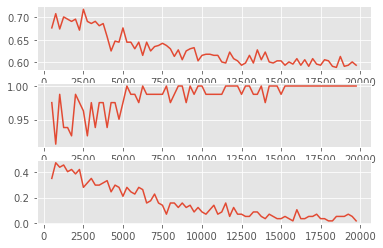

In [373]:
fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[1].plot(feat, recall_dems)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep)



As the features grew, the model began to classify more people as Democrats.  Maybe this means that republicans have a few defining words, but when the pool is broadened to more words, it gets diluted

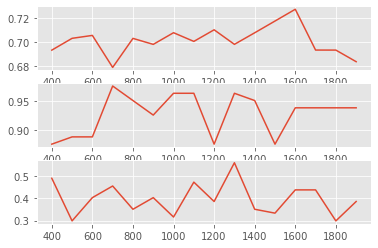

In [378]:
feat = np.arange(400, 2000, 100)
acc_small = []
recall_dems_small = []
recall_rep_small = []
for i in feat:
    clf, cvs, X_test, y_test = run_model(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc_small.append(cvs)
    recall_dems_small.append(recall_d)
    recall_rep_small.append(recall_r)

fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc_small)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[1].plot(feat, recall_dems_small)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep_small)

In [353]:
list(feat[np.argsort(acc)[-5:]])

[1500, 7000, 11750, 13000, 13750]

In [347]:
feat[np.argsort(acc)[-5:]]

array([ 1500,  7000, 11750, 13000, 13750])

## ROC Curves

In [379]:
clf, cvs, X_test, y_test = run_model(df.text, df.party, max_feat = 1300, stop_words = sw)

In [ ]:
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.808


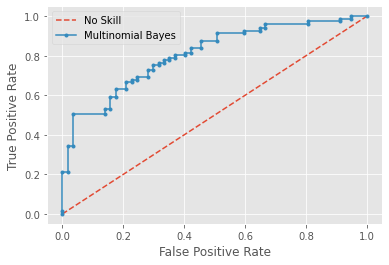

In [446]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# generate a no skill prediction (majority class)
y_test_coded = []
for i in y_test:
    if i == 'democrat':
        y_test_coded.append(1)
    else:
        y_test_coded.append(0)
    
    
ns_probs = [0 for _ in range(len(y_test))]
mnb_probs = clf.predict_proba(X_test)
# keep probabilities for being a republican only (column 1), democrat (column 0)
mnb_probs = mnb_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test_coded, ns_probs)
mnb_auc = roc_auc_score(y_test_coded, mnb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (mnb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_coded, ns_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test_coded, mnb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mnb_fpr, mnb_tpr, marker='.', label='Multinomial Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
Credit goes to https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
Credit goes to: https://www.scikit-yb.org/en/latest/api/classifier/threshold.html

### Plotting Accuracy Curves for different thresholds:

In [438]:
y_test_array = y_test.to_numpy()

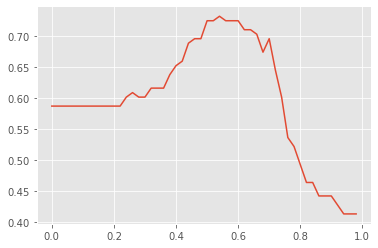

In [441]:
from statistics import mean
dem_prob = clf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
y_test
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
        else:
            correct.append(0)
    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)
    

## Random Forest

In [481]:
### fitted with grid search results
from sklearn.ensemble import RandomForestClassifier
overall_acc = []
# for i in range(10):
#     X_train, y_train, X_test, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = i)
#     rf = RandomForestClassifier()
#     rf = rf.fit(X_train, y_train)
#     acc = mean(cross_val_score(rf, X_train, y_train))
#     overall_acc.apend(acc)

# print(mean(overall_acc))

tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = 1500)
X = tfidf.fit_transform(df.text)
labels = tfidf.get_feature_names()
X_train, X_test, y_train, y_test = train_test_split(X, df.party, stratify = df.party)
rf = RandomForestClassifier(n_estimators = 600, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt',
                           max_depth = 115, bootstrap = False)
rf = rf.fit(X_train, y_train)
acc = mean(cross_val_score(rf, X_train, y_train))

pred = rf.predict(X_test)

In [482]:
acc

0.7883338230972672

said that t = 0.0, i = 0, v=0.6884722222222223 and y_test = democrat is correct
said that t = 0.0, i = 1, v=0.5929166666666668 and y_test = democrat is correct
said that t = 0.0, i = 2, v=0.7059722222222222 and y_test = democrat is correct
said that t = 0.0, i = 3, v=0.700138888888889 and y_test = democrat is correct
said that t = 0.0, i = 4, v=0.7090277777777778 and y_test = democrat is correct
said that t = 0.0, i = 5, v=0.7908333333333333 and y_test = democrat is correct
said that t = 0.0, i = 6, v=0.5440277777777777 and y_test = democrat is correct
said that t = 0.0, i = 8, v=0.6088888888888887 and y_test = democrat is correct
said that t = 0.0, i = 11, v=0.614722222222222 and y_test = democrat is correct
said that t = 0.0, i = 14, v=0.706388888888889 and y_test = democrat is correct
said that t = 0.0, i = 16, v=0.6574999999999999 and y_test = democrat is correct
said that t = 0.0, i = 19, v=0.5634722222222222 and y_test = democrat is correct
said that t = 0.0, i = 20, v=0.64763888

said that t = 0.44, i = 98, v=0.5329166666666666 and y_test = democrat is correct
said that t = 0.44, i = 101, v=0.5988888888888888 and y_test = democrat is correct
said that t = 0.44, i = 102, v=0.7519444444444444 and y_test = democrat is correct
said that t = 0.44, i = 104, v=0.3834722222222222 and y_test = republican is correct
said that t = 0.44, i = 106, v=0.7062499999999997 and y_test = democrat is correct
said that t = 0.44, i = 109, v=0.6412500000000001 and y_test = democrat is correct
said that t = 0.44, i = 110, v=0.32694444444444437 and y_test = republican is correct
said that t = 0.44, i = 111, v=0.6786111111111112 and y_test = democrat is correct
said that t = 0.44, i = 113, v=0.28375000000000006 and y_test = republican is correct
said that t = 0.44, i = 114, v=0.6500000000000001 and y_test = democrat is correct
said that t = 0.44, i = 115, v=0.4295833333333333 and y_test = republican is correct
said that t = 0.44, i = 116, v=0.5936111111111111 and y_test = democrat is cor

said that t = 0.76, i = 12, v=0.5484722222222221 and y_test = republican is correct
said that t = 0.76, i = 13, v=0.5369444444444443 and y_test = republican is correct
said that t = 0.76, i = 15, v=0.6262499999999999 and y_test = republican is correct
said that t = 0.76, i = 17, v=0.5986111111111111 and y_test = republican is correct
said that t = 0.76, i = 18, v=0.5525 and y_test = republican is correct
said that t = 0.76, i = 21, v=0.40472222222222226 and y_test = republican is correct
said that t = 0.76, i = 22, v=0.4841666666666667 and y_test = republican is correct
said that t = 0.76, i = 25, v=0.8252777777777778 and y_test = democrat is correct
said that t = 0.76, i = 27, v=0.5098611111111111 and y_test = republican is correct
said that t = 0.76, i = 28, v=0.3952777777777778 and y_test = republican is correct
said that t = 0.76, i = 29, v=0.5794444444444444 and y_test = republican is correct
said that t = 0.76, i = 31, v=0.48083333333333345 and y_test = republican is correct
said

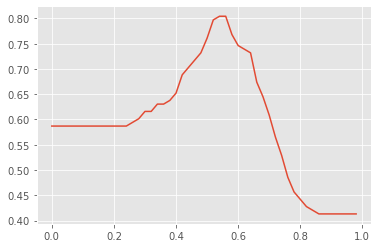

In [483]:
y_test_array = y_test.to_numpy()
dem_prob = rf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
            print(f'said that t = {t}, i = {i}, v={v} and y_test = {y_test_array[i]} is correct')
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
            print(f'said that t = {t}, i = {i}, v={v} and y_test = {y_test_array[i]} is correct')
        else:
            correct.append(0)

    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)

The best threshold is .54

In [494]:
important = rf.feature_importances_
idx = np.argsort(important)[-20:]

np.array(labels)[idx]

array(['allow', 'funding', 'major', 'inflation', 'terrorist', 'country',
       'friends', 'terrorists', 'men', 'think', 'reagan', 'economic',
       'spending', 'rates', 'federal', 'federal government', 'race',
       'bless', 'taxes', 'god bless'], dtype='<U23')

In [487]:
thresh[np.argsort(thresh_acc)[-1:]]

array([0.54])

In [486]:
print(y_test_array)

['democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'republican' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'republican'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democr

Grid search

In [464]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 220, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [543]:
#DON'T RUN THIS!!
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

## Best parameters
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 199, 'bootstrap': False}


In [ ]:
from sklearn.inspection import permutation_importance
importances = permutation_importance(rf, X_train, y_train).importances_mean

From https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

## Looking at log probabilities to find the most "democratic" and "republican" speeches

In [447]:
def get_most_partisan(clf, X_test, y_test):
    prob_dem_list = []
    sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
    for i,v in enumerate(list(clf.predict_proba(X_test))):
        prob = v[0]
        idx = list(y_test.index)[i]
        prob_dem_list.append([prob, idx])
    most_rep_idx = np.array(prob_repub_list)[sorted_idx][:5,1]
    most_dem_idx = np.array(prob_dem_list)[sorted_idx][-5:,1]
    return most_rep_idx, most_dem_idx

most_rep, most_dem = get_most_partisan(clf, X_test, y_test)
print('Most Republican')
print(df.loc[most_rep, ['name', 'title']])
print('Most Democrat')
print(df.loc[most_dem, ['name', 'title']])

Most Republican
             name                                        title
163.0      gwbush                   State of the Union Address
455.0      reagan   Address to the Nation on National Security
35.0       carter              Address to the Nation on Energy
247.0     kennedy  Special Message to the Congress on Taxation
86.0   eisenhower                      First Inaugural Address
Most Democrat
            name                                      title
255.0    kennedy                    Address on Civil Rights
281.0  lbjohnson                           Press Conference
302.0  lbjohnson          Press Conference in the East Room
289.0  lbjohnson          Press Conference in the East Room
295.0  lbjohnson  Remarks on Vietnam at Syracuse University


LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

name       party  war  \
11     bush  republican  war   
11  mondale    democrat    0   
11    obama    democrat    0   

                                               speech  \
11  <title="Address Before a Joint Session of Cong...   
11                                                  0   
11                                                  0   

                                                title           date  \
11  Address Before a Joint Session of Congress on ...  March 6, 1991   
11                                                  0              0   
11                                                  0              0   

                                                 text  interview  debate  \
11  <title="Address Before a Joint Session of Cong...      False   False   
11   One of the key tests of leadership is whether...      False    True   
11   well, thank you very much, jim, and thanks to...      False    True   

    inaugural address  state of the union  press conference  text length  \
11              False               False             False         2773   
11              False               False             False         4445   
11              False               False             False        13229   

   accurate  
11     True  
11     True  
11     True

In [279]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['end' 'energy' 'opportunity' 'done' 'billion' 'seek' 'place' 'nuclear'
 'land' 'plan' 'soviet' 'health' 'general' 'republican' 'human' 'common'
 'agreement' 'system' 'worker' 'history' 'woman' 'member' 'united nation'
 'better' 'party' 'economic' 'leader' 'see' 'care' 'back' 'never' 'act'
 'thank' 'viet-nam' 'still' 'responsibility' 'change' 'said' 'south'
 'citizen' 'long' 'interest' 'without' 'action' 'tax' 'home' 'economy'
 'community' 'together' 'military' 'much' 'give' 'well' 'take' 'program'
 'free' 'million' 'law' 'business' 'policy' 'problem' 'national' 'family'
 'security' 'future' 'tonight' 'power' 'believe' 'effort' 'good' 'bill'
 'child' 'hope' 'freedom' 'help' 'vietnam' 'job' 'need' 'life' 'force'
 'great' 'united state' 'congress' 'know' 'right' 'work' 'government'
 'america' 'think' 'united' 'new' 'country' 'state' 'peace' 'war'
 'president' 'world' 'nation' 'american' 'people']
one: ['east' 'interest' 'administration' 'toward' 'yet' 'ago' 'think' 'bill'
 'party' 

In [154]:
sw = stopwords.words('english')

new_sw = ['also', 'day','two', 'even', 'dont',"'ll", 'say', 'want', 'time', 'come', 'make', 'thing', 'le', "'m", 'go', 'thats', 'could', 'like', 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)


In [164]:
### Build confusion matrix:

In [130]:
print(clf.predict(X_test))
print(y_test)

['democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat

## Looking at correct/incorrect data

In [535]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [536]:
## Updates DF with whether the speech was accurately tagged

In [537]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    24
democrat       8
Name: party, dtype: int64

In [538]:
incorrect.debate.value_counts()

False    26
True      6
Name: debate, dtype: int64

In [539]:
correct.debate.value_counts()

False    97
True      9
Name: debate, dtype: int64

In [542]:
correct.party.value_counts()

democrat      73
republican    33
Name: party, dtype: int64

In [540]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [137]:
print((23 + 19)/(23 + 19 + 38 + 23))
print(76/473)


0.4077669902912621
0.160676532769556


In [121]:
correct = df[df['accurate']==True]

In [301]:
counts_wrong = incorrect['name'].value_counts()

In [309]:
counts_right = correct['name'].value_counts()

In [318]:
right_wrong = pd.concat([counts_wrong, counts_right], axis = 1)
right_wrong = right_wrong.fillna(0)
right_wrong['correct %'] = (1 - right_wrong.iloc[:, 0]/(right_wrong.iloc[:, 0] + right_wrong.iloc[:, 1]))*100


In [319]:
right_wrong

name  name   correct %
reagan       12.0   5.0   29.411765
ford          6.0   0.0    0.000000
bush          5.0   4.0   44.444444
nixon         3.0   0.0    0.000000
gwbush        3.0   7.0   70.000000
hoover        2.0   4.0   66.666667
eisenhower    1.0   0.0    0.000000
obama         1.0  15.0   93.750000
kennedy       1.0   8.0   88.888889
lbjohnson     0.0  20.0  100.000000
fdroosevelt   0.0  15.0  100.000000
carter        0.0   9.0  100.000000
clinton       0.0   8.0  100.000000
truman        0.0   4.0  100.000000
dukakis       0.0   2.0  100.000000
cheney        0.0   1.0  100.000000
dole          0.0   1.0  100.000000
quayle        0.0   1.0  100.000000
pence         0.0   1.0  100.000000
gore          0.0   1.0  100.000000
palin         0.0   1.0  100.000000

In [ ]:

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## To do:
- ROC Curve/Threshold
- Take out debates
- Take out LBJ
- Look up uses of top words


## Wednesday Notes

Model has great recall for Democrats, bad recall for republicans.  Nixon has the most misclassifications (Checkers!).
Debates are poorly classified.

In [156]:
incorrect

name       party  war  \
0          bush  republican  war   
5          bush  republican  war   
6          bush  republican  war   
7          bush  republican  war   
8          bush  republican  war   
10         bush  republican  war   
13         bush  republican  war   
23       carter    democrat   nw   
25       carter    democrat   nw   
26       carter    democrat   nw   
34       carter    democrat   nw   
36       carter    democrat   nw   
49      clinton    democrat   nw   
84   eisenhower  republican   nw   
144        ford  republican   nw   
148        ford  republican   nw   
149        ford  republican   nw   
152        ford  republican   nw   
156      gwbush  republican  war   
162      gwbush  republican  war   
175      gwbush  republican  war   
177      gwbush  republican  war   
187      gwbush  republican  war   
189      gwbush  republican  war   
195      hoover  republican   nw   
202      hoover  republican   nw   
203      hoover  republican   nw   
213      hoover  republican   nw   
216      hoover  republican   nw   
338       nixon  republican  war   
344       nixon  republican  war   
345       nixon  republican  war   
351       nixon  republican  war   
352       nixon  republican  war   
358       nixon  republican  war   
359       nixon  republican  war   
411      reagan  republican   nw   
415      reagan  republican   nw   
427      reagan  republican   nw   
428      reagan  republican   nw   
430      reagan  republican   nw   
443      reagan  republican   nw   
0       clinton    democrat    0   
5        reagan  republican    0   
6          dole  republican    0   
7         nixon  republican    0   
8         nixon  republican    0   
10        nixon  republican    0   
0         kaine    democrat    0   
5        romney  republican    0   
6         biden    democrat    0   
7          ryan  republican    0   
8         obama    democrat    0   
10       mccain  republican    0   
13        palin  republican    0   
23      edwards    democrat    0   
25        kerry    democrat    0   
26         gore    democrat    0   
34         gore    democrat    0   
36      clinton    democrat    0   
49      ferraro    democrat    0   

                                                speech  \
0    <title="Address at West Point">\n<date="Januar...   
5    <title="Debate with Bill Clinton and Ross Pero...   
6    <title="State of the Union Address">\n<date="J...   
7    <title="Acceptance Speech at the Republican Na...   
8    <title="Press Conference with Mikhail Gorbache...   
10   <title="Address to the Nation on Panama">\n<da...   
13   <title="Debate with Michael Dukakis">\n<date="...   
23   <title="Debate with President Gerald Ford">\n<...   
25   <title="State of the Union Address">\n<date="J...   
26   <title="Debate with President Gerald Ford">\n<...   
34   <title="President Carter's Remarks on Joint St...   
36   <title="Anti-Inflation Program Speech">\n<date...   
49   <title="Address on Somalia">\n<date="October 7...   
84   <title="Chance for Peace">\n<date="April 16, 1...   
144  <title="Address at the University of Hawaii">\...   
148  <title="Remarks on Pardoning Richard Nixon">\n...   
149  <title="Remarks on Clemency for Vietnam Era Dr...   
152  <title="Remarks in Helsinki">\n<date="August 1...   
156  <title="Remarks on Plan to Assist Automakers">...   
162  <title="Second Inaugural Address">\n<date="Jan...   
175  <title="Proposal for Global Fund to Fight HIV/...   
177  <title="First Inaugural Address">\n<date="Janu...   
187  <title="Address to the Nation on the Terrorist...   
189  <title="Remarks on No Child Left Behind Bill">...   
195  <title="Message Regarding the Farm Bill">\n<da...   
202  <title="Message Regarding “Black Thursday”">\n...   
203  <title="Remarks Upon Proclaiming the Treaty fo...   
213  <title="Message on the Gold Standard">\n<date=...   
216  <title="Message Regarding Unemployment Relief"...   
338  <title="Address to the Nation Abo

In [163]:
print(df.loc[202,'text'])


<IN REPLY to press questions as to the business situation the President said:>
"The fundamental business of the country, that is the production and distribution of commodities, is on a sound and prosperous basis. The best evidence is that although production and consumption are at high levels, the average prices of commodities as a whole have not increased and there have been no appreciable increases in the stocks of manufactured goods. Moreover, there has been a tendency of wages to increase, the output per worker in many industries again shows an increase, all of which indicates a healthy condition.
"The construction and building material industries have been to some extent affected by the high interest rates induced by stock speculation and there has been some seasonal decrease in one or two other industries but these movements are of secondary character when considered in the whole situation.
"A temporary drop in grain prices sympathetically with stock exchange prices usually happ

In [114]:
df['name'].value_counts()
mis_class_by_pres = [['bush sr', 5/27], ['carter', 2/22], ['Eisenhower', 1/6], ['Ford', 2/17], 
                     ['GW', 7/45],['Hoover',4/29], ['Nixon', 6/27], ['Obama', 1/54], ['Reagan', 10/60]]
print(mis_class_by_pres)

[['bush sr', 0.18518518518518517], ['carter', 0.09090909090909091], ['Eisenhower', 0.16666666666666666], ['Ford', 0.11764705882352941], ['GW', 0.15555555555555556], ['Hoover', 0.13793103448275862], ['Nixon', 0.2222222222222222], ['Obama', 0.018518518518518517], ['Reagan', 0.16666666666666666]]


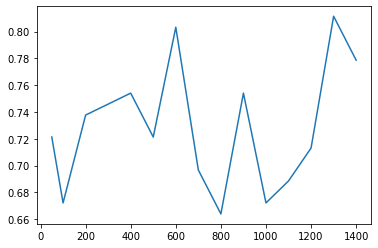

In [134]:
fig, ax = plt.subplots()
ax.plot(feat, scores)